# Metadata

```yaml
Course:    DS 5001 
Module:    12 Lab
Topic:     Classification by Lexicon
Author:    R.C. Alvarado
Date:      16 April 2023 (revised)
```

# Set Up

## Config

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_prefix = 'winereviews'
data_path = f"{data_home}/{data_prefix}/{data_prefix}"
smooth_alpha = .1

In [3]:
import pandas as pd
import numpy as np
import plotly_express as px

# Get Data

In [4]:
X_test = pd.read_pickle(f"{data_path}-X_test.csv.pickle").sort_index()
X_train = pd.read_pickle(f"{data_path}-X_train.csv.pickle").sort_index()
y_test = pd.read_pickle(f"{data_path}-y_test.csv.pickle").sort_index()
y_train = pd.read_pickle(f"{data_path}-y_train.csv.pickle").sort_index()

In [5]:
DOC = pd.read_csv(f"{data_path}-DOC_UNSPLIT.csv").set_index('doc_id')

# Create Model

In [6]:
TOKEN_CLASS = X_train.join(y_train).groupby('doc_label').sum().T

In [42]:
TOKEN_CLASS.sample(10).style.background_gradient(cmap="YlGnBu", axis=1)

doc_label,N,P
term_str,,
buffer,0.100000,2.100000
bocce,1.100000,0.100000
iowa,1.100000,0.100000
whiile,0.100000,0.100000
dumangin,1.100000,3.100000
dancer,1.100000,2.100000
pioneered,1.100000,3.100000
beaumes,1.100000,0.100000
shows,1190.100000,1690.100000


In [6]:
TOKEN_CLASS = TOKEN_CLASS + smooth_alpha
TOKEN_CLASS_LOG = np.log2(TOKEN_CLASS / TOKEN_CLASS.sum())

In [39]:
TOKEN_CLASS_LOG.sample(10).style.background_gradient(cmap="YlGnBu", axis=1)

doc_label,N,P
term_str,,
withstand,-16.749042,-17.667643
haag,-21.703238,-18.600529
prospects,-21.703238,-18.600529
rouillac,-18.243807,-22.059961
holds,-12.448210,-12.050132
establishing,-17.310921,-22.059961
riddle,-21.703238,-17.667643
burger,-15.045027,-16.387535
chewier,-21.703238,-22.059961


In [8]:
MODEL = (TOKEN_CLASS_LOG.P - TOKEN_CLASS_LOG.N).to_frame('valence')
MODEL.index.name = 'term_str'

In [68]:
MODEL['polarity'] = None
# thresh = MODEL.valence.median()
# thresh = MODEL.valence.mean()
thresh = 0
MODEL.loc[MODEL.valence >= thresh, 'polarity'] = 1
MODEL.loc[MODEL.valence < thresh, 'polarity'] = -1

In [69]:
from sklearn.preprocessing import MinMaxScaler

In [70]:
scaler = MinMaxScaler(feature_range=(-1, 1))
MODEL['normalized'] = scaler.fit_transform(MODEL[['valence']])

In [71]:
MODEL

,valence,polarity,normalized
term_str,,,
000,-0.498277,-1,-0.033041
01,0.608512,1,0.082948
02,-0.356722,-1,-0.018206
03,-1.321957,-1,-0.119360
04,-0.356722,-1,-0.018206
...,...,...,...
émilion,0.625576,1,0.084736
öküzgözü,-0.356722,-1,-0.018206
über,-0.356722,-1,-0.018206


# Model Stats

In [72]:
MODEL.valence.describe()

count    20809.000000
mean         0.367935
std          2.844002
min         -9.725229
25%         -1.162675
50%          0.233843
75%          3.102709
max          9.359240
Name: valence, dtype: float64

In [73]:
MODEL.normalized.describe()

count    20809.000000
mean         0.057736
std          0.298044
min         -1.000000
25%         -0.102668
50%          0.043683
75%          0.344333
max          1.000000
Name: normalized, dtype: float64

In [74]:
MODEL.normalized.median()

0.04368342179719466

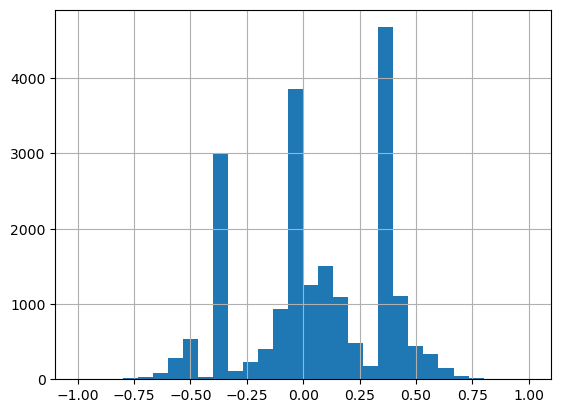

In [98]:
MODEL.normalized.hist(bins=30);

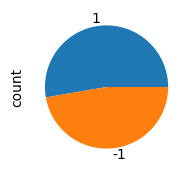

In [76]:
MODEL.polarity.value_counts().plot.pie(figsize=(2,2));

# Test Model

In [77]:
RESULT = X_test.dot(MODEL.normalized).to_frame('y_hat1')
RESULT['y_hat2'] = np.sign(RESULT.y_hat1)
RESULT['doc_label'] = y_test

In [78]:
RESULT

,y_hat1,y_hat2,doc_label
doc_id,,,
38,0.313152,1.0,N
115,0.415103,1.0,N
122,1.685138,1.0,P
128,1.457144,1.0,P
136,0.537275,1.0,P
...,...,...,...
129939,1.046527,1.0,P
129948,-0.702037,-1.0,P
129949,0.965782,1.0,P


In [79]:
RESULT.loc[RESULT.y_hat2 >= 0, 'y_hat'] = 'P'
RESULT.loc[RESULT.y_hat2 < 0, 'y_hat'] = 'N'

In [80]:
RESULT

,y_hat1,y_hat2,doc_label,y_hat
doc_id,,,,
38,0.313152,1.0,N,P
115,0.415103,1.0,N,P
122,1.685138,1.0,P,P
128,1.457144,1.0,P,P
136,0.537275,1.0,P,P
...,...,...,...,...
129939,1.046527,1.0,P,P
129948,-0.702037,-1.0,P,N
129949,0.965782,1.0,P,P


In [81]:
# RESULT.value_counts('y_hat1').sort_index().plot.bar(rot=45, figsize=(10,2));

In [82]:
# RESULT.value_counts('y_hat2').sort_index().plot.bar(rot=0);

# Evaluate Model

In [83]:
RESULT['result'] = RESULT.doc_label == RESULT.y_hat

In [84]:
CM = RESULT.value_counts(['y_hat', 'doc_label']).unstack()

In [85]:
CM.style.background_gradient(axis=None)

doc_label,N,P
y_hat,,
N,2330,282
P,1749,3639


## Recall

In [86]:
(CM / CM.sum()).style.format(precision=2).background_gradient(axis=0)

doc_label,N,P
y_hat,,
N,0.57,0.07
P,0.43,0.93


## Precision

In [87]:
(CM.T / CM.T.sum()).T.style.format(precision=2).background_gradient(axis=1)

doc_label,N,P
y_hat,,
N,0.89,0.11
P,0.32,0.68


In [93]:
# px.scatter(RESULT.join(DOC[['doc_content','points','doc_len']], how='inner', rsuffix='_x').reset_index(), 
#            'doc_len', 'points', color='result', symbol='y_hat',
#            height=900, width=1000, marginal_x='histogram', marginal_y='histogram')

In [94]:
def get_results(CM, model_id):
    
    R = pd.DataFrame(index=[model_id])
    R.index.name = 'model_id'
    
    # COUNTS
    R['TN'] = CM.iloc[0,0]   # correct rejections
    R['FN'] = CM.iloc[0,1]   # Type II errors or misses
    R['TP'] = CM.iloc[1,1]   # hits
    R['FP'] = CM.iloc[1,0]   # Type I errors or false alarms
    R['T'] = R.TP + R.TN     # All True
    R['F'] = R.FP + R.FN     # All False
    R['ALL'] = R['T'] + R.F  # All
    
    assert R.ALL.values[0] == CM.sum().sum()
    
    # RATIOS
    R['ACC'] = R['T'] / R.ALL                        # (Simple) Accuracy
    R['TPR'] = R.TP / (R.TP + R.FN)                  # Recall or Sensitivity
    R['TNR'] = R.TN / (R.TN + R.FP)                  # Specificity
    R['PPV'] = R.TP / (R.TP + R.FP)                  # Precision or Positive predictive value 
    R['BA'] = (R.TNR + R.TPR) / 2                    # Balanced Accuracy
    R['F1'] = (2 *  R.TP) / (2 * R.TP + R.FP + R.FN) # F-score where F = 1

    return R

In [95]:
R = get_results(CM, 'salex')

In [96]:
R.T.style.format(precision=2)

model_id,salex
TN,2330.00
FN,282.00
TP,3639.00
FP,1749.00
T,5969.00
F,2031.00
ALL,8000.00
ACC,0.75
TPR,0.93
TNR,0.57
